In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import librosa
import os
import random
from audiomentations import (
    Compose,
    AddGaussianNoise,
    TimeStretch,
    PitchShift,
    Shift,
    ClippingDistortion,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
# Cargar YAMNet
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

In [ ]:
# Definir augmentador
augmenter = Compose(
    [
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.7),
        TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
        PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
        Shift(min_shift=-0.2, max_shift=0.2, p=0.5),
        ClippingDistortion(
            min_percentile_threshold=0, max_percentile_threshold=40, p=0.3
        ),
    ]
)

In [ ]:
# Función para cargar y procesar audio
def process_audio(path):
    audio, sample_rate = librosa.load(path, sr=16000)
    _, embeddings, _ = yamnet_model(audio)
    average_embedding = tf.reduce_mean(embeddings, axis=0)
    return average_embedding.numpy()

In [ ]:
# Función para hacer data augmentation
def augment_audio(audio):
    audio_augmented = augmenter(samples=audio, sample_rate=16000)
    _, embeddings, _ = yamnet_model(audio_augmented)
    average_embedding = tf.reduce_mean(embeddings, axis=0)
    return average_embedding.numpy()

In [ ]:
# Procesar audios
data_path = "datasets/custom"
class_count = {}
X = []
y = []

In [7]:
# Primera pasada: contar audios originales
for category in os.listdir(data_path):
    category_folder = os.path.join(data_path, category)
    if not os.path.isdir(category_folder):
        continue
    if category == "unknown":
        total_unknown = 0
        for subfolder in os.listdir(category_folder):
            subclass_folder = os.path.join(category_folder, subfolder)
            if not os.path.isdir(subclass_folder):
                continue
            total_unknown += len(
                [f for f in os.listdir(subclass_folder) if f.endswith(".wav")]
            )
        class_count["unknown"] = total_unknown
    else:
        class_count[category] = len(
            [f for f in os.listdir(category_folder) if f.endswith(".wav")]
        )

print("Cantidad de audios por clase:", class_count)

Cantidad de audios por clase: {'car_horn': 1009, 'siren': 2223, 'unknown': 10255}


In [8]:
# Segunda pasada: cargar audios + augmentar los que necesitan
for category in os.listdir(data_path):
    category_folder = os.path.join(data_path, category)
    if not os.path.isdir(category_folder):
        continue
    if category == "unknown":
        for subfolder in os.listdir(category_folder):
            subclass_folder = os.path.join(category_folder, subfolder)
            if not os.path.isdir(subclass_folder):
                continue
            for file in os.listdir(subclass_folder):
                if file.endswith(".wav"):
                    audio_path = os.path.join(subclass_folder, file)
                    embedding = process_audio(audio_path)
                    X.append(embedding)
                    y.append("unknown")
    else:
        files = [f for f in os.listdir(category_folder) if f.endswith(".wav")]
        target = class_count["unknown"]  # Queremos acercarnos a unknown
        times = target // class_count[category]  # Cuántas veces duplicar

        for file in files:
            audio_path = os.path.join(category_folder, file)
            audio, sr = librosa.load(audio_path, sr=16000)

            # Audio original
            embedding = process_audio(audio_path)
            X.append(embedding)
            y.append(category)

            # Generar augmentations
            for _ in range(times - 1):  # Ya tenemos el original, por eso -1
                emb_aug = augment_audio(audio)
                X.append(emb_aug)
                y.append(category)

In [9]:
# Convertir a arrays
X = np.array(X)
y = np.array(y)

print("Shape de X:", X.shape)
print("Cantidad de labels:", len(y))

Shape de X: (29237, 1024)
Cantidad de labels: 29237


In [10]:
from collections import Counter

# Contar cuántos elementos hay en cada clase
class_count = Counter(y)

# Calcular el total de muestras
total_samples = sum(class_count.values())

# Ordenar de mayor a menor
sorted_classes = sorted(class_count.items(), key=lambda x: x[1], reverse=True)

# Mostrar el resultado con porcentajes
print("\n✅ Class distribution in the dataset:")
print("=" * 40)
for category, count in sorted_classes:
    percentage = (count / total_samples) * 100
    print(f"{category}: {count} samples ({percentage:.2f}%)")
print("=" * 40)


✅ Class distribution in the dataset:
unknown: 10255 samples (35.08%)
car_horn: 10090 samples (34.51%)
siren: 8892 samples (30.41%)


In [11]:
# Codificar etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [12]:
# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [13]:
# Calcular pesos de clases
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

print("Pesos de clases:", class_weights)

Pesos de clases: {0: 0.9658490254377271, 1: 1.096068231875908, 2: 0.9503087924589632}


In [ ]:
num_classes = len(np.unique(y_encoded))

model = Sequential(
    [
        Dense(256, activation="relu", input_shape=(1024,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1,
)

c:\Users\yordy\Documents\dev\bootcamp\inteligencia_artificial\fundacion_esplai\safe_drive\safe_drive_models\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
)

Epoch 1/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8566 - loss: 0.4102 - val_accuracy: 0.9359 - val_loss: 0.1998 - learning_rate: 0.0010
Epoch 2/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9187 - loss: 0.2251 - val_accuracy: 0.9414 - val_loss: 0.1636 - learning_rate: 0.0010
Epoch 3/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9380 - loss: 0.1708 - val_accuracy: 0.9519 - val_loss: 0.1542 - learning_rate: 0.0010
Epoch 4/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9409 - loss: 0.1621 - val_accuracy: 0.9504 - val_loss: 0.1405 - learning_rate: 0.0010
Epoch 5/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9442 - loss: 0.1499 - val_accuracy: 0.9496 - val_loss: 0.1482 - learning_rate: 0.0010
Epoch 6/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9505 - loss: 0.1468 - val_accuracy: 0.9558 - val_loss: 0.1273 - learning_rate: 0.0010
Epoch 7/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9492 - loss: 0.

In [16]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy:", score[1])

Test accuracy: 0.9746922254562378


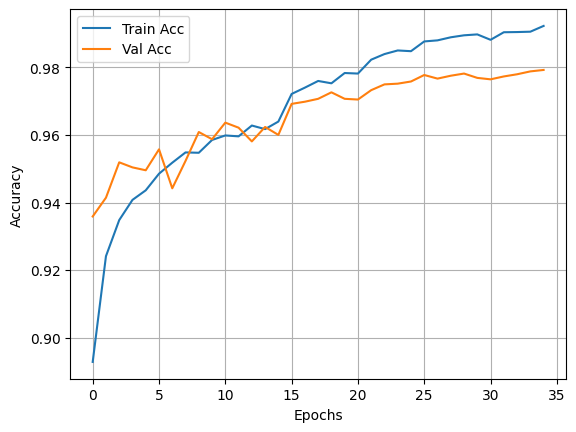

In [17]:
#  Graficar pérdidas y accuracy
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [18]:
def predict_audio(audio_path):
    audio, _ = librosa.load(audio_path, sr=16000)
    _, embeddings, _ = yamnet_model(audio)
    average_embedding = tf.reduce_mean(embeddings, axis=0).numpy()

    # Predict with Keras model
    predictions = model.predict(np.array([average_embedding]))[0]
    sorted_indices = np.argsort(predictions)[::-1]

    print(sorted_indices)
    print(f"\n🔊 Prediction for: {audio_path}")
    for i in sorted_indices:
        category = le.classes_[i]
        probability = predictions[i] * 100
        print(f"{category}: {probability:.2f}%")

In [29]:
predict_audio("audio_test/firetruck_2.wav")
# predict_audio("audio_test.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
[1 0 2]

🔊 Prediction for: audio_test/firetruck_2.wav
siren: 99.99%
car_horn: 0.00%
unknown: 0.00%


In [20]:
model.save("critical_sound_detector_model.h5")

183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


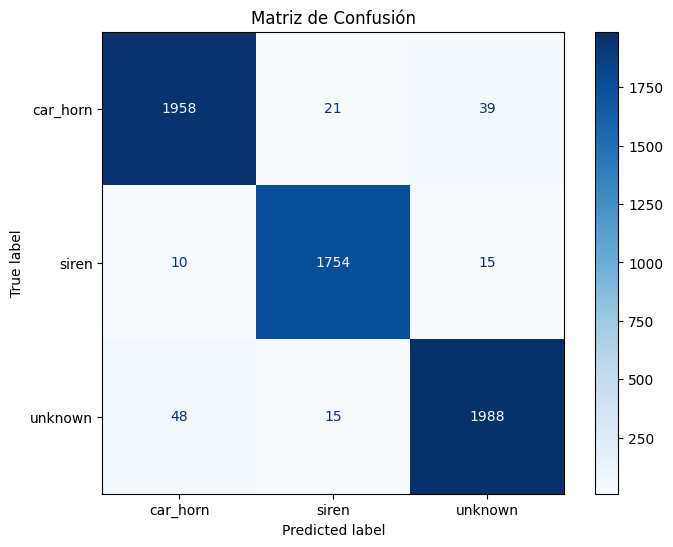

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Predecir en los datos de test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 2. Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# 3. Mostrar la matriz con etiquetas
labels = le.classes_

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(
    cmap=plt.cm.Blues, ax=ax, values_format="d"
)  # 'd' para mostrar números enteros
plt.title("Matriz de Confusión")
plt.show()

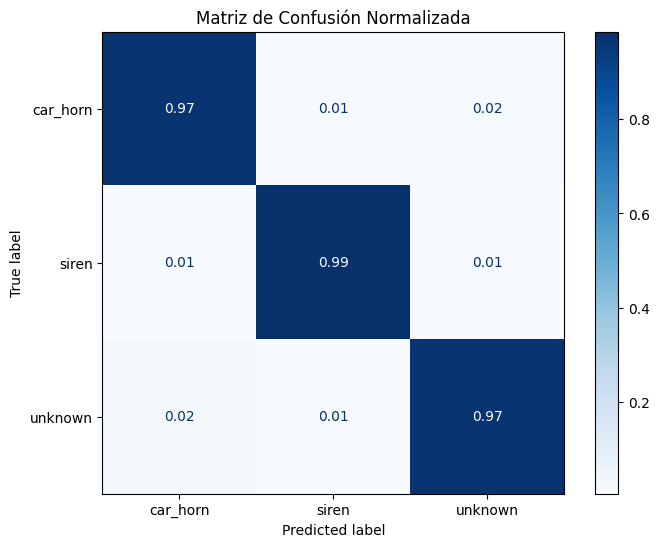

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# Normalizar manualmente
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Crear la figura
fig, ax = plt.subplots(figsize=(8, 6))

# Mostrar la matriz normalizada
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized, display_labels=le.classes_
)
disp.plot(
    cmap=plt.cm.Blues, ax=ax, values_format=".2f"
)  # AHORA sí puedes usar values_format

plt.title("Matriz de Confusión Normalizada")
plt.show()

In [23]:
from sklearn.metrics import classification_report
import pandas as pd

# Predicción
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report en formato dict
reporte_dict = classification_report(
    y_test, y_pred_classes, target_names=le.classes_, output_dict=True
)

# Lo pasamos a DataFrame
df_reporte = pd.DataFrame(reporte_dict).transpose()

# Mostrar
print("\n✅ Reporte de Clasificación en Test:")
display(
    df_reporte.style.background_gradient(cmap="Greens").format(
        {"precision": "{:.2f}", "recall": "{:.2f}", "f1-score": "{:.2f}"}
    )
)

183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

✅ Reporte de Clasificación en Test:


,precision,recall,f1-score,support
car_horn,0.97,0.97,0.97,2018.000000
siren,0.98,0.99,0.98,1779.000000
unknown,0.97,0.97,0.97,2051.000000
accuracy,0.97,0.97,0.97,0.974692
macro avg,0.97,0.98,0.98,5848.000000
weighted avg,0.97,0.97,0.97,5848.000000
